<h1 style="color: red; text-align: center; font-weight: bold;">A Comprehensive Statistical Analysis of Wuthering Waves' Gacha System</h1>

*The datasets used in this report is from WuwaTracker.com. I would like to give a massive thank you to their amazing development team!*

Greetings! My name is Dustin, and I have a passion for all things data. The objective of this analysis is to take a look at the gacha system of Wuthering Waves, and to answer the following "big picture" questions:

1. Is the gacha system behaving as expected?
2. What impact does the pity system have on pulls?
3. What is the overall behavior of the gacha system?
4. How fair is the 50/50 system?

During the course of this analysis, one thing I often encounter—especially in today’s world—is that many statistical analyses are treated as black boxes; the methodologies behind them are rarely discussed, leaving people to accept the findings at face value without understanding how the conclusions were reached. While I fully understand that not everyone has a technical background, I believe there’s always a balance to be found. 

In this report, I will walk you through the statistical methodologies I used and how I arrived at my findings and conclusions. My goal is to avoid delving too deeply into the technicalities of statistics while still providing you with a better understanding of the methods, offering insights that you can apply to your own analyses, and helping you learn more about mathematics and statistics along the way.

# <span style="color:green;">**1. Is the gacha system behaving as expected?**</span>

To answer this question, we need to compare the expected behavior (the official gacha rates given by Kuro Games) with the observed behavior (the crowdsourced statistics provided by WuwaTracker).

According to Kuro Games, the official probability of pulling a 5★ in Wuthering Waves is **0.8%**. Many people assume that for each pull, the success rate remains fixed at 0.8%, and that each pull is independent of the others. We have a name for this in probability theory, and that name is none other than the **Geometric distribution.**

#### <span style="color:blue;">*What is a Geometric Distribution?*</span>
A Geometric distribution models the number of independent trials needed to achieve the first success in trials that only have two outcomes: success or failure. In our case, trials are the number of pulls, success is when we pull a 5★, and failure is, well, failure.

The key concept in a Geometric distribution is the notion of **independence**. This means that for each pull, it gives you no information about the outcome of the next pull. In simpler terms, the probability of success remains constant at 0.8% for each pull, regardless of how many previous pulls were failures.

To determine whether the gacha system behaves as expected under a Geometric distribution, we will graph both the Expected Geometric Distribution **Probability Mass Function** (PMF) and the Observed Distribution PMF based on data from WuwaTracker. By comparing these two graphs, we can see how well the observed behavior matches the expected behavior.

#### <span style="color:blue;">*What is a Probability Mass Function (PMF)?*</span>

A Probability Mass Function (PMF) describes the probability of a specific outcome. In the context of gacha pulls, think of it this way: for each pull number (we'll call this the variable "k"), there's a certain probability of pulling a 5★. The PMF tells us the likelihood of this outcome happening at each individual pull number.

For a majority of this report, I will be using data from Camellya's banner in Patch 1.4. There's a specific reason I'm using this banner, which I'll explain in a later section. For now, let's visualize and compare the Expected and Observed PMFs.

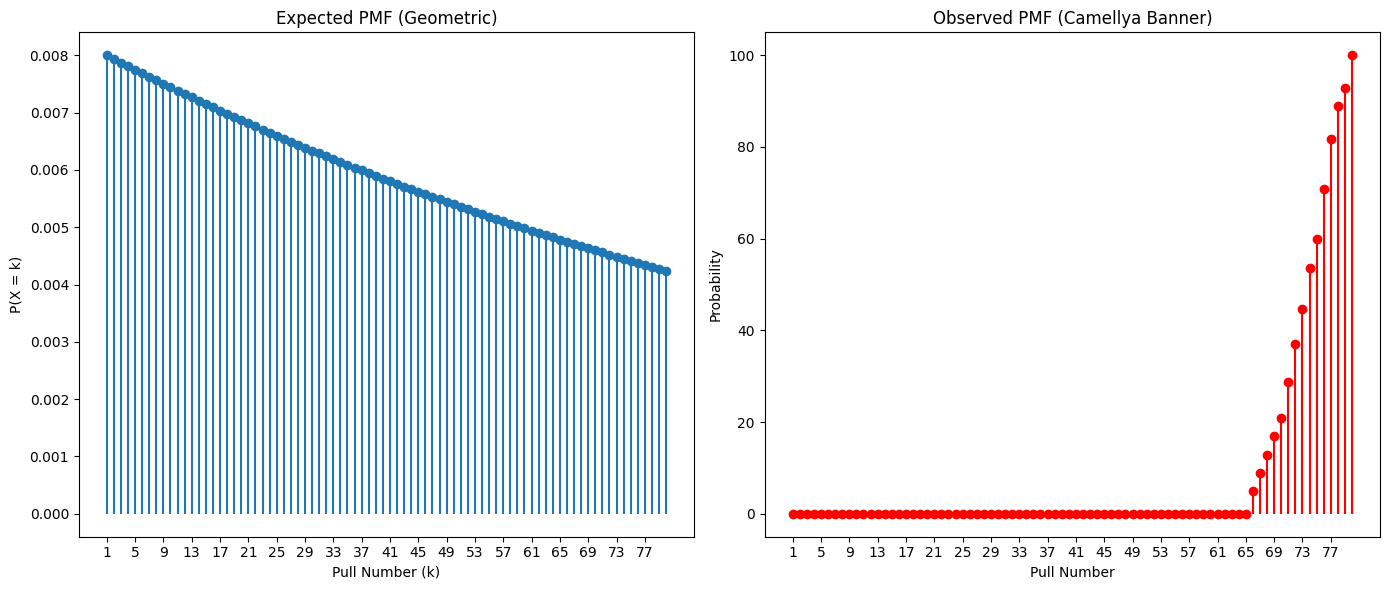

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import geom
from pandas import read_csv

# Reads in the Camellya banner probabilities that WuwaTracker has 
observed_probabilities = pd.read_csv("camellya_banner_probabilities.csv", header = None, delimiter = ",").to_numpy().flatten()

# Defines the probability and the 80 trials (pulls) of the Expected Geometric PMF
expected_probability = 0.008
trials = np.arange(1, 81)

# Calculates the individual discrete PMF values. If you want the actual formula this uses, it is the one explained below.
pmf_values = geom.pmf(trials, expected_probability)

# This entire section is dedicated to plotting the two graphs 
x_ticks = np.arange(1, max(trials) + 1, 4)
fig, axes = plt.subplots(1, 2, figsize = (14, 6))
axes[0].stem(trials, pmf_values, basefmt = " ")
axes[0].set_title("Expected PMF (Geometric)")
axes[0].set_xlabel("Pull Number (k)")
axes[0].set_xticks(x_ticks)
axes[0].set_ylabel("P(X = k)")

axes[1].stem(trials, observed_probabilities, linefmt = "r-", markerfmt = "ro", basefmt = " ")
axes[1].set_title("Observed PMF (Camellya Banner)")
axes[1].set_xlabel("Pull Number")
axes[1].set_xticks(x_ticks)
axes[1].set_ylabel("Probability")

plt.tight_layout()
plt.show()

<div style="text-align: center;">
    <strong>Figure 1.</strong> Expected and Observed PMF plots.
</div>

Now that both graphs have been plotted, we can see that the game does **not** follow a Geometric distribution as one would think. While the observed PMF is almost never going to look exactly like the expected PMF due to various error in the data, it should still be a relatively good approximate. However, this isn't a relatively good approximate at all, it is extremely far off. So, what exactly is happening here? Does this prove that the gacha system is not behaving as expected?

Not necessarily. We will see later that you can model a *part* of the gacha system with a Geometric distribution, but for now, it is very important to first analyze the two graphs that we have.

When you take a look at the left side graph which shows the Expected Geometric PMF, you might be a bit confused as to why it shows the probability of 0.008 (which is 0.8%) decreasing per pull number.

The Expected Geometric PMF comes from this formula:  
$$ P(X = k) = (1-p)^{k-1} * p $$

Don't worry, this mathematical formula is nothing complex. The ``P(X = k)`` simply represents the probability when our X variable is equal to the pull value number, which is k in this case. So, for pull number 1, to calculate the probability of that specific pull number, we do the following:
$$ P(X = 1) = (1-0.008)^{1-1}*0.008 $$

Solving for this algebraically, you just get the base probability of 0.8%. Why does it appear then that the probability decreases as the pull number increases? Well, the probability is actually remaining the same. Here, we must make the distinction between the **success** probability—which is always 0.8%—and what the Geometric PMF is modeling—the probability of getting the *first* success at the kth pull.

This means that at pull 3, for example, you need to have failed in pulls 1 and 2 before succeeding. This effect carries on the higher pull numbers you go. Hopefully, it makes intuitive sense that the more failures you have sequentially, the more of an unlikely event that becomes, hence why those probabilities in the graph get lower and lower. Try it out yourself for other "k" values such as pull number 10, 21, 47, etc.

Let us now take a look at the Observed PMF. We first must figure out how WuwaTracker is calculating their chance probabilities. If you are curious as to where I am getting the numbers from, it is this graph located in the global statistics section of the website:

<div style="text-align: center;">
    <figure>
        <img src="https://raw.githubusercontent.com/Dustin-Wuwa/Gacha-System-Analysis/be334aa045e6141910e05f5789f15eca5678f6d5/images/WuwaTracker.png" alt="Wuthering Waves Gacha Analysis" width="500">
        <figcaption><strong>Figure 2.</strong> Wuthering Waves Gacha Analysis. Adapted from WuwaTracker.com, 2025.</figcaption>
    </figure>
</div>



The "Chance" percentage that you see at each individual pull number is what I am using as the y-axis for the Observed PMF. This is calculated by WuwaTracker through a concept known as **conditional probability**.

#### <span style="color:blue;">*What is a Conditional Probability?*</span>

The conditional probability for this specific problem is given by the following formula:
$$ P(5★| \text{Pull Number } k) = \frac{P(5★ \cap \text{Pull Number } k)}{P(\text{Pull Number } k)} $$

Again, this may look complex, but I assure you, you have nothing to fear. The left-hand side states: 

**"What is the probability of a 5★ *given* the pull number k?"**

The given here is what makes this a conditional probability. We condition on the fact that we have new information: we are only looking at one specific pull, so one specific outcome.

This probability is then found by calculating the ratio of the right-hand side. The numerator states:

**"What is the probability of a 5★ in pull number k?"**

This would just be equal to the total pulls of 5★'s obtained in that specific pull number, which is given by **Figure 2**.

Now comes the interesting part, the denominator. The denominator is equal to the total amount of pulls in pull k for **all** rarity. This number isn't shown on WuwaTracker, but fortunately for us, we can reverse engineer it since we have the other values.

Using **Figure 2** as an example for pull 1, the equation becomes:
$$ P(5★ | \text{Pull Number } 1) = \frac{P(5★ \cap \text{Pull Number } 1)}{P(\text{Pull Number } 1)} $$
$$ 0.0092  = \frac{1671}{P(\text{Pull Number } 1)} $$
$$ P(\text{Pull Number } 1) = \frac{1671}{0.0092} $$

Solving for this, you get the answer to be roughly ``181,630`` total pulls at pull number 1 for all rarity. This is how WuwaTracker calculates their chance probabilities for every individual pull number.

Since WuwaTracker uses conditional probabilities to calculate their probability values, and the expected PMF uses the geometric PMF formula, this inherently tells us that the two graphs were never going to be remotely close to matching. So, why did I do this then?

Cognitive bias is the phenomenon in statistical reasoning where we want to feel that something is intuitively true, when it really is not according to the data. In this case, the example is with intuitively thinking that the gacha system behaves like a geometric distribution. Biases are a very important topic when it comes to statistical analysis, and I will be going over this more later when we get to the error segment of this report.

Since we now have knowledge of why the two graphs look the way they are, let's finally answer the burning question:

**Why does the gacha system not strictly follow a geometric distribution?**

The notion of independence is the key here. Remember, in order for a geometric distribution to work, each pull must not give you information about the next one. However, this is not the case with most gacha systems thanks to everyone's best friend, or worst nemesis depending on your luck: the **pity system**. 

# <span style="color:green;">**2. What impact does the pity system have on pulls?**</span>

The pity system does not allow us to model the gacha behavior exactly like that of a geometric distribution due to the fact that for each subsequent pull that you do, you get closer and closer to the 80 guarantee, which gives you information about your next pull. You also get closer and closer to what is known as **soft pity.**

#### <span style="color:blue;">*What is soft pity?*</span>

Have you ever wondered what the "rate-up" text that you see in the featured banners meant? Well, that's soft pity. Soft pity is the range of pulls in which the fixed success probability of 0.8% changes and starts increasing as you get closer and closer to hard pity. Hard pity is simply the guaranteed 5★ at the 80th pull.

If you take a look back at **Figure 1**, you might have noticed that for the observed PMF, the probability dots from 1-65 remain very close to each other, but at pull 66, the stem spikes up. Pulls 1-65 represent the fixed success probability of 0.8%, but starting at pull 66 and all the way to hard pity, the fixed success probability is violated and it starts increasing per pull. 

In order to figure out the behavior of the probability increase, we must first isolate the pull pity range of 66-80 and graph it.

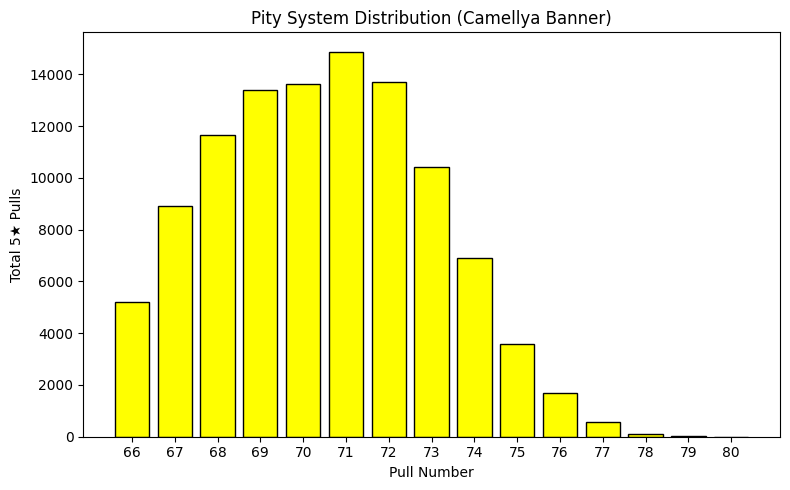

In [7]:
'''
This part of the code is responsible for generating the bar graph shown below.
I have left inline comments explaining what each part does, but please don't hesitate to ask me
a question either through the Reddit post or by directly messaging me if you are confused or are
just curious about programming!
'''

# Reads in the Camellya banner frequencies in the soft pity range that WuwaTracker has (csv file is on the Github repository!)
frequencies = pd.read_csv("camellya_banner_frequencies.csv", header = None, delimiter = ",").to_numpy().flatten()
trials = np.arange(66, 81)

# This entire section is dedicated to plotting the bar graph
plt.figure(figsize = (8, 5))
plt.bar(trials, frequencies, width=0.8, color = 'yellow', edgecolor = 'black')

plt.xlabel("Pull Number")
plt.ylabel("Total 5★ Pulls")
plt.title("Pity System Distribution (Camellya Banner)")
plt.xticks(trials)

plt.tight_layout()
plt.show()

<div style="text-align: center;">
    <strong>Figure 3.</strong> Pity System Distribution.
</div>

From this graph, we are able to make predictions about the underlying probability distribution of the pity system. If you've taken a probability or statistics course before, this graph might look familiar as it resembles a bell curve. Bell curves are typically associated with the **Normal Distribution**, a famous probability distribution. However, in this case, it's not exactly a normal distribution, as it is **right-skewed**.

A right-skewed distribution indicates that most of the pulls are concentrated on the lower end (left side), with fewer pulls occurring as the numbers increase, tapering off on the right side.

Now that we have an understanding of the frequencies (total pulls) at each pull number in the soft pity range, we can now look at how the probabilities are increasing per pull.

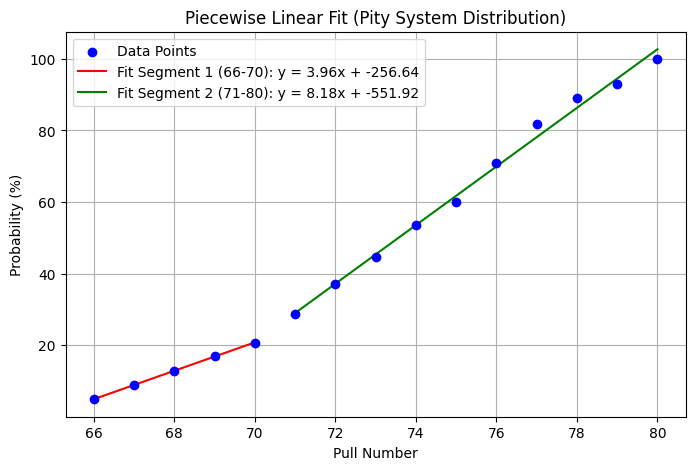

In [10]:
from sklearn.linear_model import LinearRegression

# Reads in the Camellya banner probabilities in the soft pity range that WuwaTracker has
probability_values = pd.read_csv("camellya_banner_probabilities.csv", header = None, delimiter = ",").to_numpy().flatten()
probability_values = probability_values[65:]

# This splits the range between 66-70
trials_segment_1 = trials[:5] 
probabilities_segment_1 = probability_values[:5]

# This splits the range between 71-80
trials_segment_2 = trials[5:]  
probabilities_segment_2 = probability_values[5:]

# Performs linear regression on both range segments
model_1 = LinearRegression().fit(trials_segment_1.reshape(-1, 1), probabilities_segment_1)
model_2 = LinearRegression().fit(trials_segment_2.reshape(-1, 1), probabilities_segment_2)

# Generates the fitted values
probabilities_fit_1 = model_1.predict(trials_segment_1.reshape(-1, 1))
probabilities_fit_2 = model_2.predict(trials_segment_2.reshape(-1, 1))

# This entire section is dedicated to plotting the piecewise linear fit
plt.figure(figsize = (8, 5))
plt.scatter(trials, probability_values, color = 'blue', label = 'Data Points', zorder = 5)

plt.plot(trials_segment_1, probabilities_fit_1, color = 'red', label = f'Fit Segment 1 (66-70): y = {model_1.coef_[0]:.2f}x + {model_1.intercept_:.2f}')
plt.plot(trials_segment_2, probabilities_fit_2, color = 'green', label = f'Fit Segment 2 (71-80): y = {model_2.coef_[0]:.2f}x + {model_2.intercept_:.2f}')
plt.xlabel('Pull Number')
plt.ylabel('Probability (%)')
plt.title('Piecewise Linear Fit (Pity System Distribution)')

plt.legend()
plt.grid(True)
plt.show()

<div style="text-align: center;">
    <strong>Figure 4.</strong> Piecewise Linear Fit.
</div>

As we can see from this graph, in the first 5 pulls once you hit the soft pity range, the probability increases at about a linear rate of 4% per pull. From there, it doubles with small variations to 8% for pulls 72-80. This makes intuitive sense as when we add up all the probabilities ``(4% * 5) + (8% * 10)``, you would get 100%.

Do not let the term "piecewise" confuse you here. This is still the well known linear regression method that models the linear relationship between two variables—in our case the increasing pull numbers and probability—just split into two different lines due to the overall trend of the data exhibiting different linear behaviors at certain ranges.

There is a better model out there called **logistic regression** which is more accurate when it comes to modeling the relationship between these two variables, but for the sake of simplicity, a linear model will do just fine.

Now that we have fully analyzed the pity system, it's time to circle back to our first question:

**"Is the gacha system behaving as expected?"**

The answer is yes, yes it is. We now know that due to the pity system, we can't model the *entire* range of the gacha system as a geometric distribution. We need another way to model out the overall behavior of the gacha system.

# <span style="color:green;">**3. What is the overall behavior of the gacha system?**</span>

To model the overall behavior of the gacha system, we must split it into two ranges:

For pulls 1-65, before soft pity starts, the gacha system follows that of a geometric distribution with a fixed success probability of 0.8%.

For pulls 66-80, the gacha system follows that of a rising probability distribution where probabilities start to increase per pull. For those of you who are interested in the technical name for this, it follows that of a logistic distribution.

Splitting the overall behavior of the gacha system into two ranges, does that sound familiar to you? Hopefully, it should, because we just modeled it in **Figure 4**!

This is known as a **piecewise distribution**, and it is quite common in gacha games due to the presence of the pity system in (mostly) all gacha games.

Our piecewise distribution would look something like this:

$$
P(X = k) =
\begin{cases}
\text{Geometric Distribution} & \text{for} \ k \in [1, 65] \\
\text{Rising Probability Distribution} & \text{for} \ k \in [66, 80]
\end{cases}
$$

Now that we’ve established the overall behavior of the gacha system, that opens up a new question: how accurate is our model?

We now dive into the most crucial aspect of any statistical analysis, **error**.

## <span style="color:purple;">**Error**</span>

A professor of mine once told me when I was in university that "Any measurement that you make without the knowledge of its uncertainty is completely meaningless." This is referring to something known as the measurement uncertainty. In the case of statistics, the two main sources of uncertainty in measurements is **bias** and **variance**. These two together make up a large portion of the error in any dataset.

There is no such thing as "perfect" data. Error will *always* exist in all datasets. There's two types of error in statistical modeling: reducible error and irreducible error (yes, mathematicians are very creative at naming things). 

While there are various statistical methods available to reduce reducible error—such as addressing variance in the dataset and correcting for selective and reporting bias—we are lucky enough to have a powerful tool from probability theory that significantly mitigates reducible error. This tool is one of the two most fundamental concepts in all of probability theory: **The Law of Large Numbers** (LLN).

#### <span style="color:blue;">*What is the Law of Large Numbers (LLN)?*</span>

I told you, we mathematicians are very creative when it comes to names.

The Law of Large Numbers (LLN) is exactly what it sounds like. Due to the sheer number of pulls in Camellya's banner, which is nearing 9.4 million, LLN states that the probabilities we have calculated should converge to their true values as the sample size increases. While I won’t delve into the formal proof of this mathematical law—since it’s quite involved and would require several pages of explanation—it should be intuitive. For example, if you are sampling the average height of all students in a classroom, the more people you sample, the closer your sample average will be to the true population average. Similarly, in our case, as the number of pulls increases, the calculated probabilities will converge more closely to their true values.

Thanks to LLN, we don't need to rely on the other statistical methods such as confidence intervals for assessing the accuracy and precision of our measurements. With such a massive dataset, we should already have a very good estimate of the gacha system's true behavior.

# <span style="color:green;">**4. How fair is the 50/50 system?**</span>

In order to quantify this, we must first take a look at how 50/50 actually works. 

When you pull a 5★, you have the chance of getting the featured resonator, or a standard resonator. If you lose the 50/50, your next 5★ is **guaranteed** to be the featured resonator.

If we compare this to flipping a fair coin—let's have heads be a success and tails be a loss—if the coin lands on tails, there is no mechanic out there in the Universe that will guarantee you that the next flip lands on heads. So, is it really a split 50/50 chance in the long run between getting a featured resonator and standard resonator?

The answer is no. While each individual pull does have a 50/50 chance of yielding either a featured or a standard resonator, the mechanics of the system are designed to favor the appearance of the featured resonator more than the standard one. This is because, once you lose the 50/50, the next pull is guaranteed to reward you with the featured resonator, which means that in the long run, you will get the featured resonator approximately $ \frac{2}{3} $
 of the time.

This is an important observation because it highlights the non-intuitive nature of the 50/50 mechanic: while it may seem like a simple 50/50 split, the guarantee system creates a bias towards the featured resonator, making it more likely to be pulled in the long run than the standard one.

This is our expected behavior, does the data support it? Well, if we take a look at Camellya's banner on WuwaTracker, we find the following:

<div style="text-align: center;">
    <figure>
        <img src="https://raw.githubusercontent.com/Dustin-Wuwa/Gacha-System-Analysis/be334aa045e6141910e05f5789f15eca5678f6d5/images/Camellya_Pulls.png" alt="Camellya Pulls" width="500">
        <figcaption><strong>Figure 5.</strong> Camellya Pulls. Adapted from WuwaTracker.com, 2025.</figcaption>
    </figure>
</div>

Camellya makes up roughly $ \frac{2}{3} $ of the 5★ characters pulled. If you sift through all the other banners on WuwaTracker, you will also see this trend. The expected behavior is supported by the data, which proves that the 50/50 system, as much as we despise it, is fair.

# <span style="color:gold;">**Closing Remarks**</span>

*Does your analysis apply to the weapon banner*?

With the exception of the 50/50 system, yes.

*Why did you use Camellya's banner?*

I used Camellya's banner because it is one of a very few set of banners where WuwaTracker actually recorded someone getting a 5★ character at exactly hard pity. For the majority of the time, you can think of the guaranteed 80 as more of a theoretical guarantee. It is **very** rare for you to actually have to go all the way to hard pity, but it can still unfortunately happen!

*It states in the gacha statistic rates in-game that the overall resonator base drop rate is 1.8%?*

Yes, yes it does. This is the advertised average rate that Kuro Games has listed. In order for us to see if the data supports this, we simply take this ratio:
$$ \text{Average Resonator Base Drop Rate} = \frac{\text{Total 5* Pulls}}{\text{Total Pulls}} $$

If we use the statistics on WuwaTracker for Camellya's banner, and fill in the ratio:
$$ \text{Average Resonator Base Drop Rate} = \frac{\text{182756}}{\text{9387795}} $$

This is roughly 1.95%, which is a 8% difference to 1.8%. As most engineers would say, it's good enough!

Thank you for taking the time to read this long report. I hope you learned something new about the gacha system of Wuthering Waves, and hopefully learned something new in general about mathematics. My next project will be a comprehensive statistical analysis on the substat distribution of Wuthering Waves. If you would like to contribute your echo substats for data analysis, please visit this Dropbox [link](https://www.dropbox.com/scl/fo/58c8vw1mioa6vk6uj6rca/AJMWBHWsgr_SbUrtZc-RRNM?rlkey=fpepsdkyq9j9psdqaoaq85csl&st=1ik9fwx2&dl=0) and upload images of your echoes there. Until next time!